# 06 Auto Feature Search

---

## 1. Setup project paths and load base feature set

Set up the project root path and load the previously engineered baseline feature set.


In [24]:
import os, sys
import pandas as pd
import numpy as np

# Determine project root (one level above notebooks/)
proj_root = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
if proj_root not in sys.path:
    sys.path.insert(0, proj_root)

# Paths
DATA_DIR = os.path.join(proj_root, "data")
OUTPUT_DIR = os.path.join(proj_root, "outputs")
os.makedirs(OUTPUT_DIR, exist_ok=True)


## 2. Load raw data and define EntitySet for Featuretools

Load all relevant tables and define relationships between them for Deep Feature Synthesis.


In [25]:
import featuretools as ft

# Load all necessary data
df_app    = pd.read_csv(os.path.join(DATA_DIR, "application_train.csv"))
df_prev   = pd.read_csv(os.path.join(DATA_DIR, "previous_application.csv"))
df_bureau = pd.read_csv(os.path.join(DATA_DIR, "bureau.csv"))
df_bbal   = pd.read_csv(os.path.join(DATA_DIR, "bureau_balance.csv"))
df_inst   = pd.read_csv(os.path.join(DATA_DIR, "installments_payments.csv"))
df_cc_bal = pd.read_csv(os.path.join(DATA_DIR, "credit_card_balance.csv"))
df_pos    = pd.read_csv(os.path.join(DATA_DIR, "POS_CASH_balance.csv"))

# Create EntitySet
es = ft.EntitySet(id="homecredit_full")

# Add dataframes with explicit named arguments
es = es.add_dataframe(
    dataframe_name="app",
    dataframe=df_app,
    index="SK_ID_CURR"
)
es = es.add_dataframe(
    dataframe_name="previous",
    dataframe=df_prev,
    make_index=True,
    index="PREV_INDEX",
    time_index="DAYS_DECISION"
)
es = es.add_relationship(
    parent_dataframe_name="app",
    parent_column_name="SK_ID_CURR",
    child_dataframe_name="previous",
    child_column_name="SK_ID_CURR"
)

es = es.add_dataframe(
    dataframe_name="bureau",
    dataframe=df_bureau,
    index="SK_ID_BUREAU"
)
es = es.add_dataframe(
    dataframe_name="bureau_balance",
    dataframe=df_bbal,
    make_index=True,
    index="BBAL_INDEX"
)
es = es.add_relationship(
    parent_dataframe_name="bureau",
    parent_column_name="SK_ID_BUREAU",
    child_dataframe_name="bureau_balance",
    child_column_name="SK_ID_BUREAU"
)
es = es.add_relationship(
    parent_dataframe_name="app",
    parent_column_name="SK_ID_CURR",
    child_dataframe_name="bureau",
    child_column_name="SK_ID_CURR"
)

es = es.add_dataframe(
    dataframe_name="inst",
    dataframe=df_inst,
    make_index=True,
    index="INST_INDEX",
    time_index="DAYS_ENTRY_PAYMENT"
)
es = es.add_relationship(
    parent_dataframe_name="app",
    parent_column_name="SK_ID_CURR",
    child_dataframe_name="inst",
    child_column_name="SK_ID_CURR"
)

es = es.add_dataframe(
    dataframe_name="ccbal",
    dataframe=df_cc_bal,
    make_index=True,
    index="CC_INDEX",
    time_index="MONTHS_BALANCE"
)
es = es.add_relationship(
    parent_dataframe_name="app",
    parent_column_name="SK_ID_CURR",
    child_dataframe_name="ccbal",
    child_column_name="SK_ID_CURR"
)

es = es.add_dataframe(
    dataframe_name="pos",
    dataframe=df_pos,
    make_index=True,
    index="POS_INDEX",
    time_index="MONTHS_BALANCE"
)
es = es.add_relationship(
    parent_dataframe_name="app",
    parent_column_name="SK_ID_CURR",
    child_dataframe_name="pos",
    child_column_name="SK_ID_CURR"
)

c:\Users\tgruenecker\AppData\Local\Programs\Python\Python312\Lib\site-packages\woodwork\type_sys\utils.py:33: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(
c:\Users\tgruenecker\AppData\Local\Programs\Python\Python312\Lib\site-packages\woodwork\type_sys\utils.py:33: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(
c:\Users\tgruenecker\AppData\Local\Programs\Python\Python312\Lib\site-packages\woodwork\type_sys\utils.py:33: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(
c:\Users\tgruenecker\AppData\Local\Programs\Python\Python312\Lib

## 3. Perform Deep Feature Synthesis (DFS)

Use Featuretools to automatically generate aggregated features across related tables.


In [26]:
feature_matrix_full, feature_defs_full = ft.dfs(
    entityset=es,
    target_dataframe_name="app",
    agg_primitives=["mean", "sum", "count", "max", "min", "std"],
    trans_primitives=[],
    max_depth=2,
    n_jobs=1
)

feature_matrix_full = feature_matrix_full.reset_index()
print("DFS feature matrix shape:", feature_matrix_full.shape)

# Save
feature_matrix_full.to_csv(os.path.join(OUTPUT_DIR, "dfs_features_full.csv"), index=False)

c:\Users\tgruenecker\AppData\Local\Programs\Python\Python312\Lib\site-packages\featuretools\computational_backends\feature_set_calculator.py:785: FutureWarning: The provided callable <function min at 0x000001C9BA82EE80> is currently using SeriesGroupBy.min. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "min" instead.
  ).agg(to_agg)
c:\Users\tgruenecker\AppData\Local\Programs\Python\Python312\Lib\site-packages\featuretools\computational_backends\feature_set_calculator.py:785: FutureWarning: The provided callable <function mean at 0x000001C9BA82F740> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  ).agg(to_agg)
c:\Users\tgruenecker\AppData\Local\Programs\Python\Python312\Lib\site-packages\featuretools\computational_backends\feature_set_calculator.py:785: FutureWarning: The provided callable <f

DFS feature matrix shape: (307511, 548)


## 4. Merge manually selected and auto-generated features

Clean column names and merge both feature sets into a single dataframe.


In [27]:
import re

baseline_file = os.path.join(proj_root, "outputs", "01_train_features_first_baseline.csv")
dfs_file      = os.path.join(proj_root, "outputs", "dfs_features_full.csv")
out_file      = os.path.join(proj_root, "outputs", "03_train_features_autosearch_baseline.csv")

df_base = pd.read_csv(baseline_file)
df_dfs  = pd.read_csv(dfs_file)

# Function to sanitize column names
def sanitize(col):
    s = re.sub(r'[^0-9A-Za-z_]', '_', col)
    return re.sub(r'__+', '_', s).strip('_')

# Clean column names in dfs features
df_dfs.columns = [
    c if c in ("SK_ID_CURR", "TARGET") else sanitize(c)
    for c in df_dfs.columns
]

df_comb = (
    df_base
    .merge(df_dfs, on=["SK_ID_CURR", "TARGET"], how="left")
    .fillna(0)
)

df_comb.to_csv(out_file, index=False)
print(f"Combined features saved to: {out_file}")

Combined features saved to: c:\Users\tgruenecker\OneDrive\Desktop\Master_Studium\3. Semester\Home_Credit_Projekt\Home_Credit_Project\outputs\03_train_features_autosearch_baseline.csv


## 5. Train LightGBM on combined features

Evaluate model performance using cross-validation.


In [28]:
from sklearn.model_selection import StratifiedKFold
import lightgbm as lgb
from src.feature_selection_utils import evaluate_auc

df = pd.read_csv(out_file)

# Convert object columns to category
for c in df.select_dtypes(include=['object']).columns:
    df[c] = df[c].astype('category')

y = df['TARGET']
X = df.drop(columns=['SK_ID_CURR','TARGET'])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
model = lgb.LGBMClassifier(random_state=42)

evaluate_auc(X, y, model, cv, name="Baseline Combined Features")

[Baseline Combined Features] AUC: 0.78493 ± 0.00431


(0.7849300575021425, 0.004305619100579209)

## 6. Select features using the Elbow Method

Train a model and use the elbow point of cumulative feature importances to retain the most relevant features.

In [29]:
from kneed import KneeLocator

# Train model on full feature set
model.fit(X, y)
importances = pd.Series(model.feature_importances_, index=X.columns)

# Sort and compute cumulative importance
imp_sorted = importances.sort_values(ascending=False)
cum_imp = imp_sorted.cumsum() / imp_sorted.sum()

# Find elbow point
kl = KneeLocator(
    x=list(range(len(cum_imp))),
    y=cum_imp.values,
    curve="concave",
    direction="increasing"
)
cutoff = kl.knee
print(f"Elbow at rank {cutoff}, cumulative importance: {cum_imp.values[cutoff]:.2%}")

# Select features up to elbow
selected_feats = imp_sorted.index[: cutoff + 1].tolist()
X_imp = X[selected_feats]
print("Shape after elbow filtering:", X_imp.shape)

# Evaluate
evaluate_auc(X_imp, y, model, cv, name="After Elbow Importance Filter")

[LightGBM] [Info] Number of positive: 24825, number of negative: 282686
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.572011 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 109265
[LightGBM] [Info] Number of data points in the train set: 307511, number of used features: 575
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432486
[LightGBM] [Info] Start training from score -2.432486
Elbow at rank 138, cumulative importance: 82.90%
Shape after elbow filtering: (307511, 139)
[After Elbow Importance Filter] AUC: 0.78531 ± 0.00410


(0.7853119155345413, 0.004097963248524901)

## 7. Remove highly correlated features

Drop one feature from each pair of highly correlated features based on importance.

In [30]:
# Only use numeric features
X_num = X_imp.select_dtypes(include=[np.number])

# Absolute correlation matrix
corr_matrix = X_num.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Identify pairs above threshold
drop_info = []
threshold = 0.90
for col in upper.columns:
    for other in upper.index[upper[col] > threshold]:
        corr_val = upper.at[other, col]
        if importances[col] < importances[other]:
            drop_info.append((col, other, corr_val))
        else:
            drop_info.append((other, col, corr_val))

to_drop = list({feat for feat, _, _ in drop_info})

print("Dropping the following highly correlated features:")
for feat, corr_with, corr_val in drop_info:
    print(f"- {feat} (corr={corr_val:.2f}) with {corr_with}")

X_corr = X_imp.drop(columns=to_drop)
print("Shape after correlation filtering:", X_corr.shape)

evaluate_auc(X_corr, y, model, cv, name="After Correlation Filter")

Dropping the following highly correlated features:
- AMT_CREDIT (corr=0.99) with AMT_GOODS_PRICE_x
- SUM_inst_AMT_INSTALMENT (corr=0.98) with SUM_inst_AMT_PAYMENT
- STD_inst_DAYS_ENTRY_PAYMENT (corr=1.00) with STD_inst_DAYS_INSTALMENT
- MAX_previous_AMT_DOWN_PAYMENT (corr=0.91) with SUM_previous_AMT_DOWN_PAYMENT
- SUM_bureau_AMT_CREDIT_MAX_OVERDUE (corr=0.95) with MEAN_bureau_AMT_CREDIT_MAX_OVERDUE
- STD_pos_MONTHS_BALANCE (corr=0.91) with STD_inst_DAYS_INSTALMENT
- STD_pos_MONTHS_BALANCE (corr=0.91) with STD_inst_DAYS_ENTRY_PAYMENT
- EXT_SOURCE_2_x (corr=0.99) with EXT_SOURCE_2_y
- MEAN_pos_SK_DPD_DEF (corr=0.97) with STD_pos_SK_DPD_DEF
- MAX_inst_DAYS_INSTALMENT (corr=1.00) with MAX_inst_DAYS_ENTRY_PAYMENT
- MEAN_pos_CNT_INSTALMENT (corr=0.96) with pc_CNT_INSTALMENT_FUTURE_MEAN
- MAX_bureau_AMT_CREDIT_MAX_OVERDUE (corr=0.95) with MEAN_bureau_AMT_CREDIT_MAX_OVERDUE
- MAX_bureau_AMT_CREDIT_MAX_OVERDUE (corr=1.00) with SUM_bureau_AMT_CREDIT_MAX_OVERDUE
- bur_CREDIT_COUNT_SUM (corr=0.90)

(0.7852553751011244, 0.004084851223267064)

## 8. SHAP-based Recursive Feature Elimination

Drop least important features based on SHAP values and evaluate AUC after each step.


[LightGBM] [Info] Number of positive: 19860, number of negative: 226148
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.100234 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 24626
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 117
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432482
[LightGBM] [Info] Start training from score -2.432482


c:\Users\tgruenecker\AppData\Local\Programs\Python\Python312\Lib\site-packages\shap\explainers\_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


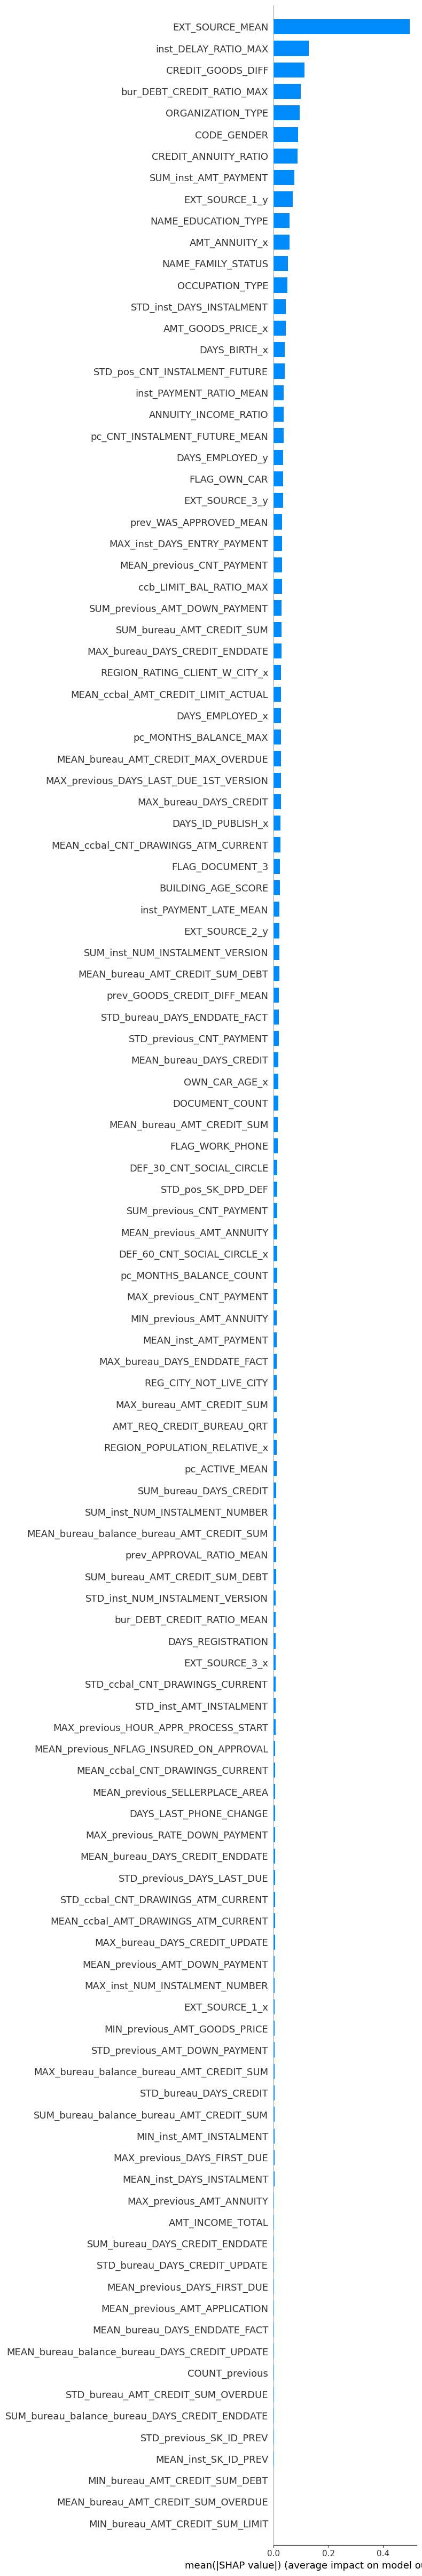

In [31]:
import shap
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Prepare data
X = X_corr.copy()
y = df['TARGET']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# SHAP helper function
def compute_shap_values(model, X_background, X_target):
    explainer = shap.TreeExplainer(model)
    shap_vals = explainer.shap_values(X_target)
    return shap_vals[1] if isinstance(shap_vals, list) else shap_vals

model = lgb.LGBMClassifier(random_state=42)
model.fit(X_train, y_train)

shap_values = compute_shap_values(model, X_train, X_test)

# Plot summary
shap.summary_plot(shap_values, X_test, plot_type="bar", max_display=shap_values.shape[1])

## 9. Iteratively eliminate least important SHAP features

Evaluate performance as features are dropped based on SHAP ranking.


In [19]:
def iteratively_drop_least_important_features(X, y, shap_vals, max_drop):
    mean_shap = np.abs(shap_vals).mean(axis=0)
    feature_ranking = pd.Series(mean_shap, index=X.columns).sort_values()

    model = lgb.LGBMClassifier(random_state=42)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    print("Iterative SHAP Feature Elimination (CV-AUC):")
    print("n_dropped | AUC      | STD     | Dropped Features")
    print("--------------------------------------------------------------")

    for n in range(1, max_drop + 1):
        to_drop = feature_ranking.index[:n].tolist()
        X_reduced = X.drop(columns=to_drop)
        mean_auc, std_auc = evaluate_auc(X_reduced, y, model, cv, verbose=False)
        print(f"{n:<9} | {mean_auc:.5f} | {std_auc:.5f} | {', '.join(to_drop)}")

# Run for up to 50 dropped features
iteratively_drop_least_important_features(X, y, shap_values, max_drop=100)

Iterative SHAP Feature Elimination (CV-AUC):
n_dropped | AUC      | STD     | Dropped Features
--------------------------------------------------------------
1         | 0.78556 | 0.00347 | MIN_bureau_AMT_CREDIT_SUM_LIMIT
2         | 0.78495 | 0.00410 | MIN_bureau_AMT_CREDIT_SUM_LIMIT, SUM_ccbal_AMT_DRAWINGS_ATM_CURRENT
3         | 0.78551 | 0.00405 | MIN_bureau_AMT_CREDIT_SUM_LIMIT, SUM_ccbal_AMT_DRAWINGS_ATM_CURRENT, MAX_previous_SK_ID_PREV
4         | 0.78548 | 0.00360 | MIN_bureau_AMT_CREDIT_SUM_LIMIT, SUM_ccbal_AMT_DRAWINGS_ATM_CURRENT, MAX_previous_SK_ID_PREV, SUM_previous_SELLERPLACE_AREA
5         | 0.78532 | 0.00422 | MIN_bureau_AMT_CREDIT_SUM_LIMIT, SUM_ccbal_AMT_DRAWINGS_ATM_CURRENT, MAX_previous_SK_ID_PREV, SUM_previous_SELLERPLACE_AREA, MIN_pos_CNT_INSTALMENT
6         | 0.78551 | 0.00359 | MIN_bureau_AMT_CREDIT_SUM_LIMIT, SUM_ccbal_AMT_DRAWINGS_ATM_CURRENT, MAX_previous_SK_ID_PREV, SUM_previous_SELLERPLACE_AREA, MIN_pos_CNT_INSTALMENT, MIN_bureau_AMT_CREDIT_SUM_DEBT
7    

KeyboardInterrupt: 

Dropping the 33 least important features (based on SHAP values) yielded the highest AUC of **0.78599**.  
However, I ultimately decided to drop **56 features**, as the benefit of further dimensionality reduction and improved interpretability was prioritized over achieving the absolute maximum AUC. This has still a very good AUC of **0.78527**
46 bei filled ext am besten mit 0,78612, bzw. 18 hatte 0,7684, aber zu wenig drop, das wären immerhin 0.001 auc mehr

## 10. Save final feature set after SHAP-RFE

Drop 56 least relevant features based on SHAP and save new baseline feature set.


In [ ]:
# Compute mean absolute SHAP values and sort ascending
mean_shap = np.abs(shap_values).mean(axis=0)
shap_importance = pd.Series(mean_shap, index=X.columns).sort_values()

# Drop the 56 least important features
features_to_drop = shap_importance.index[:56].tolist()
X_final = X.drop(columns=features_to_drop)
df_final = df[["SK_ID_CURR", "TARGET"]].join(X_final)

# Save final feature set
out_path = os.path.join(OUTPUT_DIR, "03_train_features_autosearch_baseline.csv")
df_final.to_csv(out_path, index=False)
print(f"Saved to {out_path}, shape: {df_final.shape}")

# Evaluate performance
mean_auc, std_auc = evaluate_auc(X_final, y, model, cv, name="Final SHAP-RFE Feature Baseline")

## 11. Log final model and features to Weights & Biases

Track experiment metrics and selected features for reproducibility.


In [ ]:
import wandb

# Initialize wandb run
wandb.init(
    project="home_credit_default",
    name="03_autosearch_baseline",
    config={
        "model": "lightgbm",
        "selection": "SHAP + Elbow + Correlation",
    }
)

# Log scalar metrics
wandb.log({
    "auc": mean_auc,
    "cv_std": std_auc,
    "n_features": X_final.shape[1],
})

# Log feature names as summary
wandb.summary["feature_names"] = X_final.columns.tolist()

wandb.finish()